In [228]:
!pip install statsmodels
# test


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [229]:
!pip install geopandas


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [230]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib
import seaborn
import matplotlib.pyplot as plt

In [231]:
#import Pop_County
df_census2020 = pd.read_csv('DECENNIALPL2020.P1-2024-11-10T174624.csv')
df_population_bycounty = df_census2020.head(1)
df_population_bycounty.columns = df_population_bycounty.columns.str.replace(' County, California', '', regex=False)
county_names = df_population_bycounty.columns[1:]
populations = df_population_bycounty.iloc[0, 1:].replace(',', '', regex=True).astype(int)
df_population_bycounty = pd.DataFrame({
    'County': county_names,
    'Population': populations
}).reset_index(drop=True)
df_population_bycounty = df_population_bycounty.rename(columns={'County': 'CountyName'})
print(len(df_population_bycounty))
df_population_bycounty.head()
# county_names


58


,CountyName,Population
0,Alameda,1682353
1,Alpine,1204
2,Amador,40474
3,Butte,211632
4,Calaveras,45292


In [232]:
# import hospital data

# df_hospital = pd.read_csv('ed-volume-and-capacity-2021.csv', encoding = "ISO-8859-1", index_col=[0])
# df_hospital = df_hospital[df_hospital["Category"] == "Asthma"]
# df_hospital_bycounty = df_hospital.groupby('CountyName')['EDDXCount'].sum().reset_index()
# df_hospital_bycounty.head()

df_hospital = pd.read_csv('asthma-emergency-department-visit-rates-by-county-2015_2022.csv', encoding = "ISO-8859-1")
df_hospital_bycounty = df_hospital[df_hospital["STRATA NAME"] == "All ages"]
df_hospital_bycounty = df_hospital_bycounty[df_hospital_bycounty["YEAR"] <= 2019]
df_hospital_bycounty = df_hospital_bycounty.rename(columns={'COUNTY': 'CountyName'})
df_hospital_bycounty = df_hospital_bycounty[["CountyName", "YEAR", "NUMBER OF ED VISITS"]]
df_hospital_bycounty = df_hospital_bycounty[df_hospital_bycounty["CountyName"] != "California"]
print(len(df_hospital_bycounty))
df_hospital_bycounty.head()

290


,CountyName,YEAR,NUMBER OF ED VISITS
1,Alameda,2015,"9,939"
2,Alpine,2015,0
3,Amador,2015,196
4,Butte,2015,"1,044"
5,Calaveras,2015,185


In [233]:
df_hospital_pop_bycounty = pd.merge(df_population_bycounty, df_hospital_bycounty, on='CountyName', how='inner')
df_hospital_pop_bycounty["NUMBER OF ED VISITS"] = df_hospital_pop_bycounty["NUMBER OF ED VISITS"].replace({',': ''}, regex=True)
df_hospital_pop_bycounty["NUMBER OF ED VISITS"] = pd.to_numeric(df_hospital_pop_bycounty["NUMBER OF ED VISITS"])
df_hospital_pop_bycounty["NormalizedVisits"] = df_hospital_pop_bycounty["NUMBER OF ED VISITS"] /  df_hospital_pop_bycounty["Population"] * 10000

df_hospital_pop_bycounty = df_hospital_pop_bycounty[df_hospital_pop_bycounty['NormalizedVisits'] >= 10] # remove 1 outlier 

print(len(df_hospital_pop_bycounty))
df_hospital_pop_bycounty.head(n=6)

284


,CountyName,Population,YEAR,NUMBER OF ED VISITS,NormalizedVisits
0,Alameda,1682353,2015,9939.0,59.077970
1,Alameda,1682353,2016,9086.0,54.007690
2,Alameda,1682353,2017,8942.0,53.151746
3,Alameda,1682353,2018,7795.0,46.333914
4,Alameda,1682353,2019,7448.0,44.271327
10,Amador,40474,2015,196.0,48.426150


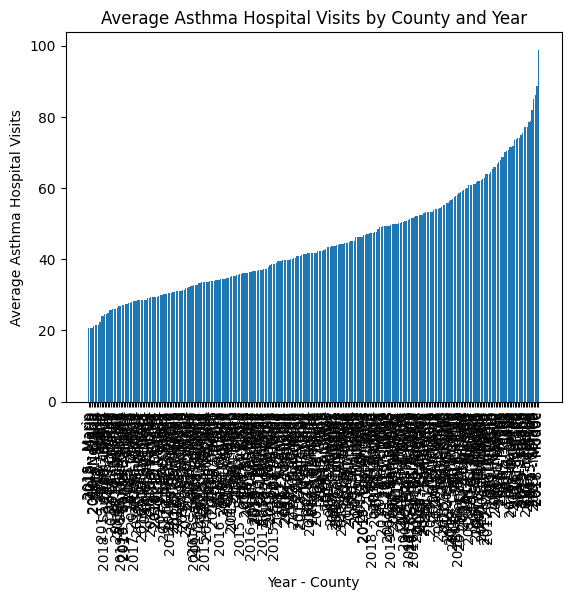

In [234]:
df_hospital_pop_bycounty['YearCounty'] = df_hospital_pop_bycounty['YEAR'].astype(str) + ' - ' + df_hospital_pop_bycounty['CountyName']
df_hospital_pop_bycounty_sorted = df_hospital_pop_bycounty.sort_values(by='NormalizedVisits', ascending=True)
plt.bar(df_hospital_pop_bycounty_sorted['YearCounty'], df_hospital_pop_bycounty_sorted['NormalizedVisits'])
plt.xticks(rotation=90)
plt.xlabel('Year - County')
plt.ylabel('Average Asthma Hospital Visits')
plt.title('Average Asthma Hospital Visits by County and Year')
plt.show()

In [235]:
# import matplotlib.pyplot as plt

# df_hospital_pop_bycounty_sorted = df_hospital_pop_bycounty.sort_values(by='NormalizedVisits', ascending=True)

# plt.bar(df_hospital_pop_bycounty_sorted['CountyName'], df_hospital_pop_bycounty_sorted['NormalizedVisits'])
# plt.xticks(range(df_hospital_pop_bycounty_sorted['CountyName'].shape[0]), df_hospital_pop_bycounty_sorted['CountyName'], rotation='vertical')
# plt.xlabel('County')
# plt.ylabel('Average Asthma Hospital Visits')
# plt.title('Average Asthma Hospital Visits by County')
# plt.show()

In [236]:
# Function to count number of days with aqi at or worse than 100
def make_aqi_df(csv_name, year):
    df_air = pd.read_csv(csv_name, encoding = "ISO-8859-1", index_col=[0])
    df_air = df_air.groupby('County')['Daily AQI Value'].apply(lambda x: (x >= 100).sum()).reset_index()
    df_air = df_air.rename(columns={'Daily AQI Value': 'days over 100'})
    df_air['Year'] = year
    return df_air[['County', 'Year', 'days over 100']]

In [237]:
# import air quality data
df_air_2019 = make_aqi_df('air_quality_2019.csv', '2019')
df_air_2018 = make_aqi_df('air_quality_2018.csv', '2018')
df_air_2017 = make_aqi_df('air_quality_2017.csv', '2017')
df_air_2016 = make_aqi_df('air_quality_2016.csv', '2016')
df_air_2015 = make_aqi_df('air_quality_2015.csv', '2015')


# data selection/merging
df_air_by_county = pd.concat([df_air_2015, df_air_2016, df_air_2017, df_air_2018, df_air_2019], axis=0)# Combine all years into one dataframe
df_air_by_county = df_air_by_county.rename(columns={'County': 'CountyName'})
# df_air_by_county = df_air_by_county.rename(columns={'Daily AQI Value': 'days over 100'})

print(df_air_by_county.columns)
df_air_by_county.head()

Index(['CountyName', 'Year', 'days over 100'], dtype='object')


,CountyName,Year,days over 100
0,Alameda,2015,5
1,Alpine,2015,16
2,Butte,2015,6
3,Calaveras,2015,4
4,Colusa,2015,6


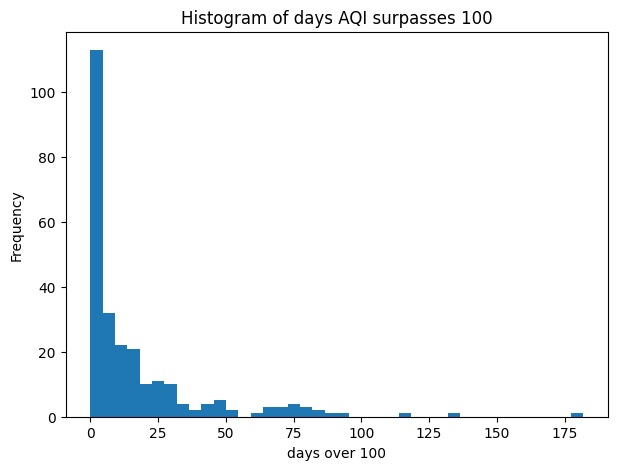

In [238]:
# plot histogram of number of days over 100
plt.figure(figsize=(7, 5))
plt.hist(df_air_by_county['days over 100'], bins=40)
plt.xlabel('days over 100')
plt.ylabel('Frequency')
plt.title('Histogram of days AQI surpasses 100')
plt.show()


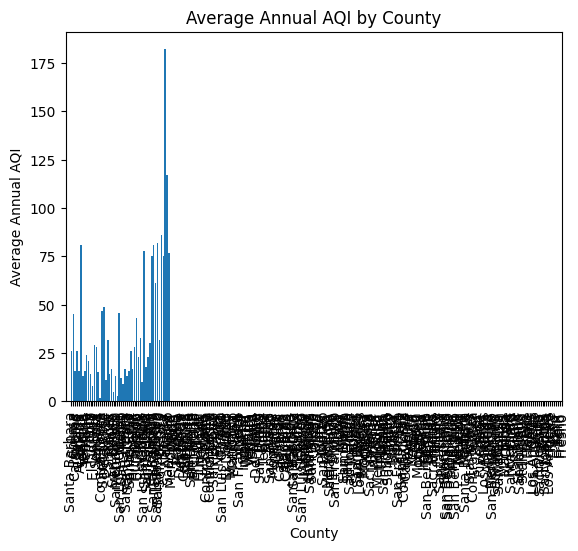

In [239]:
# Bar plot of AQI by county
import matplotlib.pyplot as plt
# plt.bar(df_air_by_county['CountyName'], df_air_by_county['AverageAnnualAQI'])
# plt.xticks(range(df_air_by_county['CountyName'].shape[0]), df_air_by_county['CountyName'], rotation='vertical')
# plt.show()

df_air_by_county_sorted = df_air_by_county.sort_values(by='days over 100', ascending=True)

plt.bar(df_air_by_county_sorted['CountyName'], df_air_by_county_sorted['days over 100'])
plt.xticks(range(df_air_by_county_sorted['CountyName'].shape[0]), df_air_by_county_sorted['CountyName'], rotation='vertical')
plt.xlabel('County')
plt.ylabel('Average Annual AQI')
plt.title('Average Annual AQI by County')
plt.show()


<Axes: xlabel='CountyName', ylabel='days over 100'>

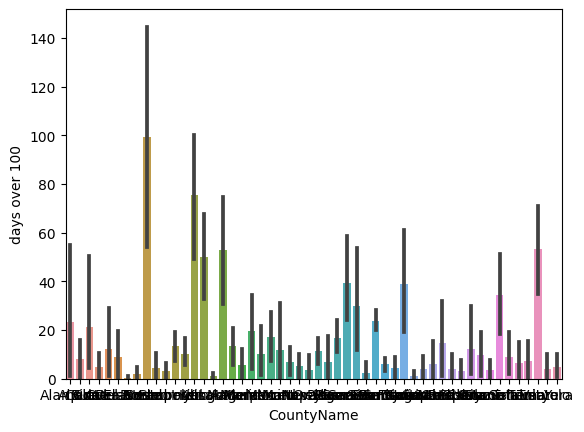

In [241]:
# Bar plot of AQI by county
# seaborn.barplot(data = df_air_by_county, x="CountyName", y="AverageAnnualAQI")
seaborn.barplot(data = df_air_by_county, x="CountyName", y="days over 100")

In [242]:
df_hospital_pop_bycounty = df_hospital_pop_bycounty.rename(columns={"YEAR": "Year"})
df_hospital_pop_bycounty.head(n=10)

,CountyName,Population,Year,NUMBER OF ED VISITS,NormalizedVisits,YearCounty
0,Alameda,1682353,2015,9939.0,59.077970,2015 - Alameda
1,Alameda,1682353,2016,9086.0,54.007690,2016 - Alameda
2,Alameda,1682353,2017,8942.0,53.151746,2017 - Alameda
3,Alameda,1682353,2018,7795.0,46.333914,2018 - Alameda
4,Alameda,1682353,2019,7448.0,44.271327,2019 - Alameda
10,Amador,40474,2015,196.0,48.426150,2015 - Amador
11,Amador,40474,2016,187.0,46.202500,2016 - Amador
12,Amador,40474,2017,176.0,43.484706,2017 - Amador
13,Amador,40474,2018,137.0,33.848891,2018 - Amador
14,Amador,40474,2019,169.0,41.755201,2019 - Amador


In [243]:
df_air_by_county["Year"] = df_air_by_county["Year"].astype("int64")
df_air_by_county.head()

,CountyName,Year,days over 100
0,Alameda,2015,5
1,Alpine,2015,16
2,Butte,2015,6
3,Calaveras,2015,4
4,Colusa,2015,6


In [244]:
# merge AQI and hospital data
df_hospital_aqi = pd.merge(df_hospital_pop_bycounty[["CountyName", "Year", "NormalizedVisits"]], df_air_by_county, on=["Year", "CountyName"], how='inner')
print(len(df_hospital_aqi))
df_hospital_aqi.head(n=50)

255


,CountyName,Year,NormalizedVisits,days over 100
0,Alameda,2015,59.077970,5
1,Alameda,2016,54.007690,0
2,Alameda,2017,53.151746,31
3,Alameda,2018,46.333914,81
4,Alameda,2019,44.271327,0
5,Butte,2015,49.330914,6
6,Butte,2016,36.383912,3
7,Butte,2017,44.227716,14
8,Butte,2018,42.857413,78
9,Butte,2019,35.580631,5


<Axes: xlabel='days over 100', ylabel='NormalizedVisits'>

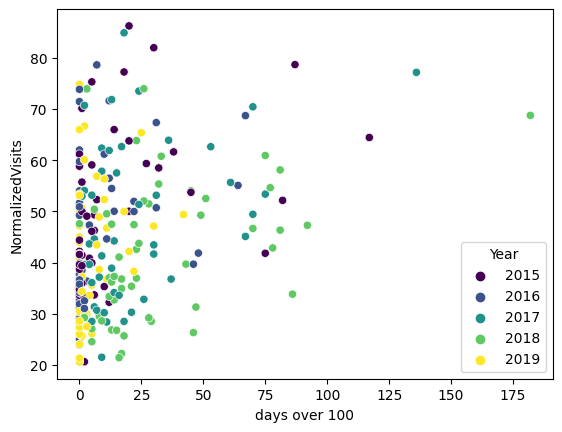

In [245]:
seaborn.scatterplot(data=df_hospital_aqi, x='days over 100', y='NormalizedVisits', hue='Year', palette='viridis')

In [ ]:
# plot Hospital Visits by AQI per county in 2021
# seaborn.scatterplot(data = df_hospital_aqi, x='AverageAnnualAQI', y='NormalizedVisits')

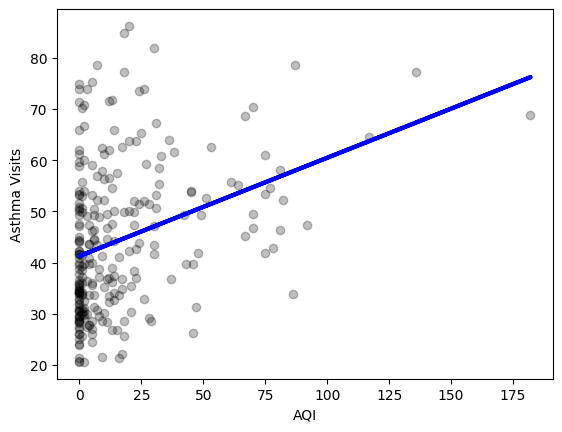

In [246]:
import statsmodels.api as sm

df_hospital_aqi = df_hospital_aqi.dropna(subset=['NormalizedVisits', 'days over 100'])

x = df_hospital_aqi["days over 100"]
y = df_hospital_aqi["NormalizedVisits"]

# In order to have an intercept, we need to add a column of 1's to X
x2 = sm.add_constant(x)

# Fit the simple linear regression
sm_model = sm.OLS(y, x2)
results = sm_model.fit()

# Make predictions using the linear regression
y_pred = results.predict(x2)

# Plot 
plt.scatter(x, y,  color='black', alpha = 0.25)
plt.plot(x, y_pred, color='blue', linewidth=3)
plt.xlabel('AQI')
plt.ylabel('Asthma Visits')
plt.show()

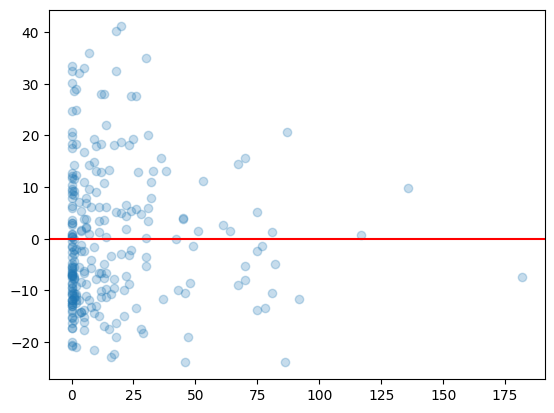

In [247]:
# Enter code here to plot the residuals (Question 7a)
residuals = y - y_pred
plt.scatter(x, residuals, alpha = 0.25)
plt.axhline(y=0, color = 'red')
plt.show()

In [248]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       NormalizedVisits   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     31.76
Date:                Sat, 23 Nov 2024   Prob (F-statistic):           4.65e-08
Time:                        15:17:32   Log-Likelihood:                -1028.7
No. Observations:                 255   AIC:                             2061.
Df Residuals:                     253   BIC:                             2068.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            41.2776      1.024     40.319

In [249]:
# import cjest
df_cjest = pd.read_csv('1.0-communities.csv', low_memory=False)
df_cjest = df_cjest[df_cjest['State/Territory'] == 'California']
# Select only the desired columns
df_cjest = df_cjest[['Census tract 2010 ID', 
                     'County Name', 
                     'State/Territory', 
                     'Percent Black or African American alone', 
                     'Percent American Indian / Alaska Native', 
                     'Percent Asian', 
                     'Percent Native Hawaiian or Pacific', 
                     'Percent two or more races', 
                     'Percent White', 
                     'Percent Hispanic or Latino', 
                     'Percent other races', 
                     'Identified as disadvantaged', 
                     'Percentage of tract that is disadvantaged by area', 
                     'Total population', 
                     'Is low income?', 
                     'Adjusted percent of individuals below 200% Federal Poverty Line (percentile)', 
                     'Adjusted percent of individuals below 200% Federal Poverty Line']]

# Display the resulting dataframe
df_cjest.head()

,Census tract 2010 ID,County Name,State/Territory,Percent Black or African American alone,Percent American Indian / Alaska Native,Percent Asian,Percent Native Hawaiian or Pacific,Percent two or more races,Percent White,Percent Hispanic or Latino,Percent other races,Identified as disadvantaged,Percentage of tract that is disadvantaged by area,Total population,Is low income?,Adjusted percent of individuals below 200% Federal Poverty Line (percentile),Adjusted percent of individuals below 200% Federal Poverty Line
3560,6001400100,Alameda County,California,0.03,0.00,0.12,0.0,0.05,0.74,0.03,0.01,False,0,3120.0,False,0.08,0.01
3561,6001400200,Alameda County,California,0.02,0.00,0.08,0.0,0.09,0.73,0.08,0.00,False,0,2007.0,False,0.12,0.03
3562,6001400300,Alameda County,California,0.09,0.00,0.11,0.0,0.01,0.67,0.06,0.02,False,0,5051.0,False,0.09,0.02
3563,6001400400,Alameda County,California,0.07,0.01,0.10,0.0,0.07,0.63,0.12,0.04,False,0,4007.0,False,0.30,0.12
3564,6001400500,Alameda County,California,0.21,0.00,0.10,0.0,0.15,0.45,0.09,0.02,False,0,4124.0,False,0.23,0.09


In [250]:
df_cjest["Disadvantaged Numeric"] = df_cjest["Identified as disadvantaged"].astype(int)
df_county_disadvantaged_status = (
    df_cjest.groupby("County Name")
    .apply(lambda group: (
        group["Disadvantaged Numeric"] * group["Total population"]
    ).sum() / group["Total population"].sum())
    .reset_index(name="Weighted Disadvantaged")
)
df_county_disadvantaged_status["County identified as disadvantaged"] = df_county_disadvantaged_status["Weighted Disadvantaged"] >= 0.5
df_county_disadvantaged_status = df_county_disadvantaged_status.rename(columns={"County Name": "CountyName"})
df_county_disadvantaged_status["CountyName"] = df_county_disadvantaged_status["CountyName"].str.replace(" County", "", regex=False).str.strip()
df_county_disadvantaged_status.head()

,CountyName,Weighted Disadvantaged,County identified as disadvantaged
0,Alameda,0.245741,False
1,Alpine,1.000000,True
2,Amador,0.051576,False
3,Butte,0.379024,False
4,Calaveras,0.224502,False


In [251]:
df_hospital_aqi.head()

,CountyName,Year,NormalizedVisits,days over 100
0,Alameda,2015,59.077970,5
1,Alameda,2016,54.007690,0
2,Alameda,2017,53.151746,31
3,Alameda,2018,46.333914,81
4,Alameda,2019,44.271327,0


In [252]:
# merge in disadvantaged column to existing dataframe
df_hospital_aqi_disadvant = pd.merge(df_county_disadvantaged_status[["CountyName", "County identified as disadvantaged"]], df_hospital_aqi, on=["CountyName"])
print(len(df_hospital_aqi_disadvant))
df_hospital_aqi_disadvant.head()

255


,CountyName,County identified as disadvantaged,Year,NormalizedVisits,days over 100
0,Alameda,False,2015,59.077970,5
1,Alameda,False,2016,54.007690,0
2,Alameda,False,2017,53.151746,31
3,Alameda,False,2018,46.333914,81
4,Alameda,False,2019,44.271327,0


In [253]:
# divide based on disadvantaged or not

disadvantaged_county_data = df_hospital_aqi_disadvant[df_hospital_aqi_disadvant["County identified as disadvantaged"] == True]
not_disadvantaged_county_data = df_hospital_aqi_disadvant[df_hospital_aqi_disadvant["County identified as disadvantaged"] == False]

print(disadvantaged_county_data.head())
print(not_disadvantaged_county_data.head())

   CountyName  County identified as disadvantaged  Year  NormalizedVisits  \
15     Colusa                                True  2015         44.415953   
16     Colusa                                True  2016         30.679060   
17     Colusa                                True  2017         28.389578   
18     Colusa                                True  2018         54.031778   
19     Colusa                                True  2019         47.163332   

    days over 100  
15              6  
16              0  
17             11  
18             45  
19              0  
  CountyName  County identified as disadvantaged  Year  NormalizedVisits  \
0    Alameda                               False  2015         59.077970   
1    Alameda                               False  2016         54.007690   
2    Alameda                               False  2017         53.151746   
3    Alameda                               False  2018         46.333914   
4    Alameda                         

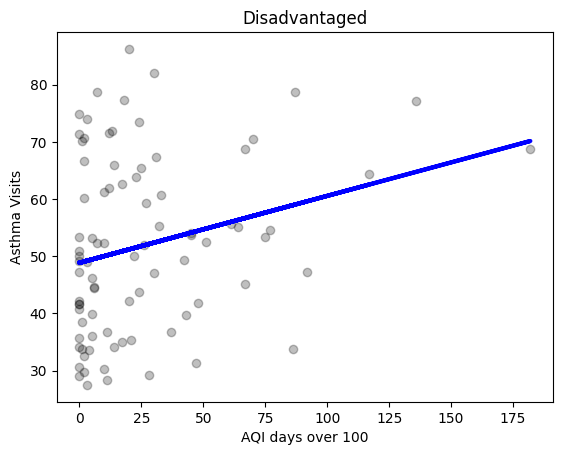

In [255]:
# run linear regression on disadvantaged counties

x_dis = disadvantaged_county_data["days over 100"]
y_dis = disadvantaged_county_data["NormalizedVisits"]

# In order to have an intercept, we need to add a column of 1's to X
x2_dis = sm.add_constant(x_dis)

# Fit the simple linear regression
sm_model_dis = sm.OLS(y_dis, x2_dis)
results_dis = sm_model_dis.fit()

# Make predictions using the linear regression
y_pred_dis = results_dis.predict(x2_dis)

# Plot 
plt.scatter(x_dis, y_dis,  color='black', alpha = 0.25)
plt.plot(x_dis, y_pred_dis, color='blue', linewidth=3)
plt.xlabel('AQI days over 100')
plt.ylabel('Asthma Visits')
plt.title('Disadvantaged')
plt.show()

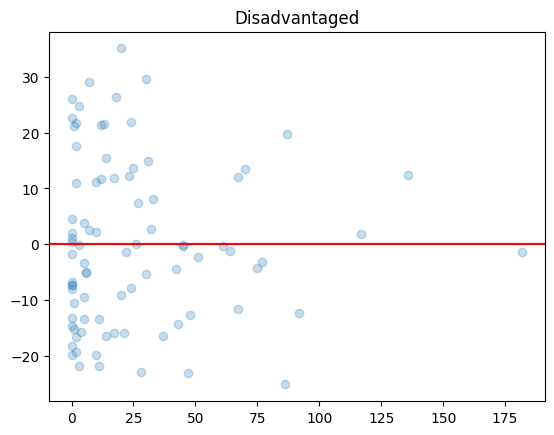

In [256]:
residuals_dis = y_dis - y_pred_dis
plt.scatter(x_dis, residuals_dis, alpha = 0.25)
plt.axhline(y=0, color = 'red')
plt.title("Disadvantaged")
plt.show()

In [257]:
print(results_dis.summary())

                            OLS Regression Results                            
Dep. Variable:       NormalizedVisits   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     5.862
Date:                Sat, 23 Nov 2024   Prob (F-statistic):             0.0177
Time:                        15:18:06   Log-Likelihood:                -349.22
No. Observations:                  85   AIC:                             702.4
Df Residuals:                      83   BIC:                             707.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            48.8500      2.042     23.921

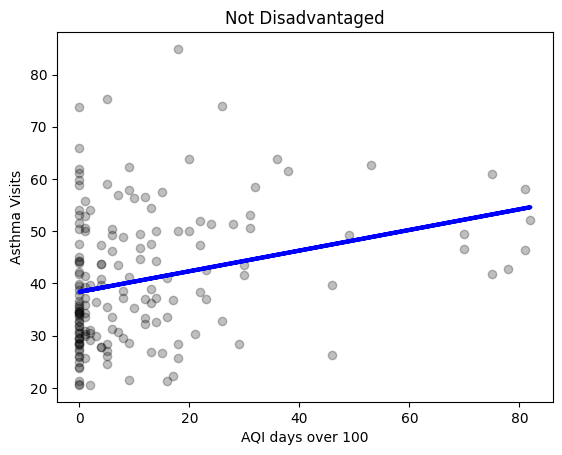

In [258]:
# not disadvantaged

x_no_dis = not_disadvantaged_county_data["days over 100"]
y_no_dis = not_disadvantaged_county_data["NormalizedVisits"]

# In order to have an intercept, we need to add a column of 1's to X
x2_no_dis = sm.add_constant(x_no_dis)

# Fit the simple linear regression
sm_model_no_dis = sm.OLS(y_no_dis, x2_no_dis)
results_no_dis = sm_model_no_dis.fit()

# Make predictions using the linear regression
y_pred_no_dis = results_no_dis.predict(x2_no_dis)

# Plot 
plt.scatter(x_no_dis, y_no_dis,  color='black', alpha = 0.25)
plt.plot(x_no_dis, y_pred_no_dis, color='blue', linewidth=3)
plt.xlabel('AQI days over 100')
plt.ylabel('Asthma Visits')
plt.title('Not Disadvantaged')
plt.show()

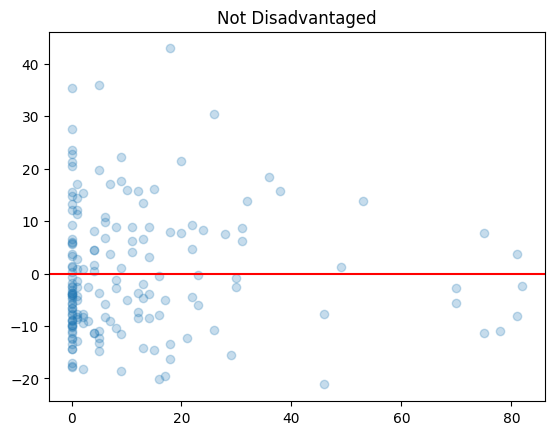

In [259]:
residuals_no_dis = y_no_dis - y_pred_no_dis
plt.scatter(x_no_dis, residuals_no_dis, alpha = 0.25)
plt.axhline(y=0, color = 'red')
plt.title("Not Disadvantaged")
plt.show()

In [261]:
print(results_no_dis.summary())

                            OLS Regression Results                            
Dep. Variable:       NormalizedVisits   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     14.80
Date:                Sat, 23 Nov 2024   Prob (F-statistic):           0.000169
Time:                        15:18:18   Log-Likelihood:                -664.16
No. Observations:                 170   AIC:                             1332.
Df Residuals:                     168   BIC:                             1339.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            38.3959      1.103     34.819

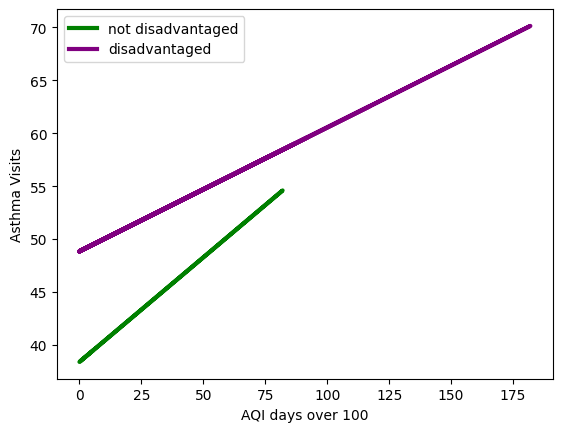

In [262]:
plt.plot(x_no_dis, y_pred_no_dis, color='green', linewidth=3, label="not disadvantaged")
plt.plot(x_dis, y_pred_dis, color='purple', linewidth=3, label="disadvantaged")
plt.xlabel('AQI days over 100')
plt.ylabel('Asthma Visits')
plt.legend()
plt.show()

<Axes: xlabel='CountyName', ylabel='days over 100'>

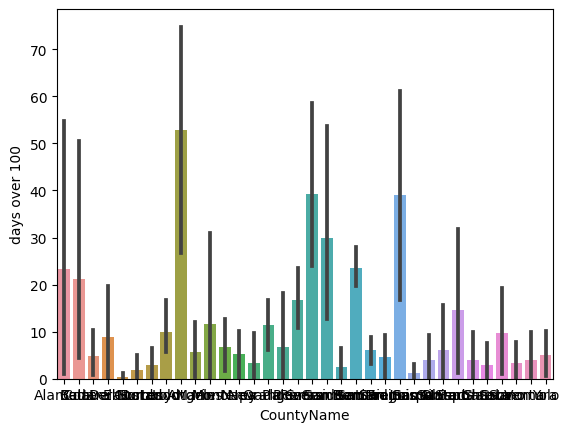

In [263]:
seaborn.barplot(data = not_disadvantaged_county_data, x="CountyName", y="days over 100")

<Axes: xlabel='CountyName', ylabel='days over 100'>

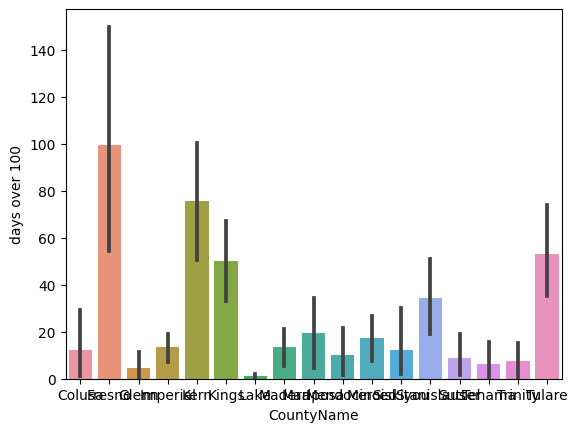

In [264]:
seaborn.barplot(data = disadvantaged_county_data, x="CountyName", y="days over 100")

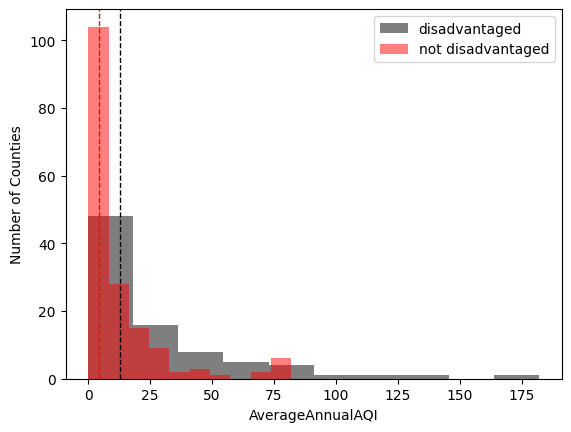

In [267]:
plt.hist(disadvantaged_county_data['days over 100'], 
         alpha=0.5, # the transaparency parameter
         color='black',
         label='disadvantaged')
  
plt.hist(not_disadvantaged_county_data['days over 100'],
         alpha=0.5,
         color = 'red',
         label='not disadvantaged')

plt.axvline(disadvantaged_county_data['days over 100'].median(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(not_disadvantaged_county_data['days over 100'].median(), color='red', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('AverageAnnualAQI')
plt.ylabel('Number of Counties')
plt.show()

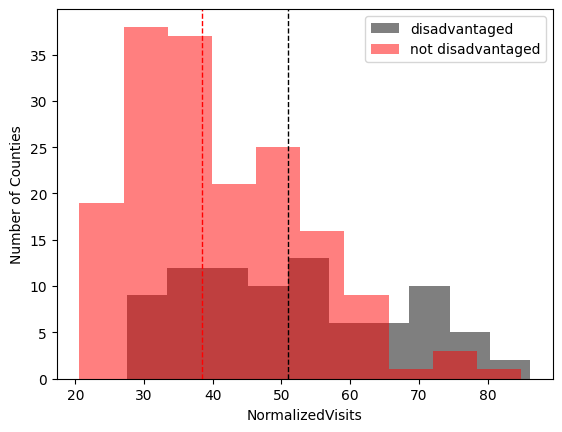

In [268]:
plt.hist(disadvantaged_county_data['NormalizedVisits'], 
         alpha=0.5, # the transaparency parameter
         color='black',
         label='disadvantaged')
  
plt.hist(not_disadvantaged_county_data['NormalizedVisits'],
         alpha=0.5,
         color = 'red',
         label='not disadvantaged')

plt.axvline(disadvantaged_county_data['NormalizedVisits'].median(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(not_disadvantaged_county_data['NormalizedVisits'].median(), color='red', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('NormalizedVisits')
plt.ylabel('Number of Counties')
plt.show()

In [269]:
from scipy.stats import median_test
stat, p, med, tbl = median_test(disadvantaged_county_data['NormalizedVisits'], not_disadvantaged_county_data['NormalizedVisits'])
print('The p-value for the Moods Median test is ', p)
print('The grand median (median for all both samples together) is ', med)
print('The contingency table is: \n', tbl)
if (p < 0.01):
        print("There IS a statistically significant difference between the mediansdisadvantaged and not disadvantaged counties for Asthma Hospital Visits")
else: 
        print("There is NOT a statistically significant difference between the mediansdisadvantaged and not disadvantaged counties for Asthma Hospital Visits")

The p-value for the Moods Median test is  5.587690331978727e-05
The grand median (median for all both samples together) is  41.85011318553339
The contingency table is: 
 [[ 58  69]
 [ 27 101]]
There IS a statistically significant difference between the mediansdisadvantaged and not disadvantaged counties for Asthma Hospital Visits


In [270]:
from scipy.stats import median_test
stat, p, med, tbl = median_test(disadvantaged_county_data['days over 100'], not_disadvantaged_county_data['days over 100'])
print('The p-value for the Moods Median test is ', p)
print('The grand median (median for all both samples together) is ', med)
print('The contingency table is: \n', tbl)
if (p < 0.01):
        print("There IS a statistically significant difference between the mediansdisadvantaged and not disadvantaged counties for AQI")
else: 
        print("There is NOT a statistically significant difference between the mediansdisadvantaged and not disadvantaged counties for AQI")

The p-value for the Moods Median test is  0.008973389799690848
The grand median (median for all both samples together) is  6.0
The contingency table is: 
 [[52 73]
 [33 97]]
There IS a statistically significant difference between the mediansdisadvantaged and not disadvantaged counties for AQI


In [271]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


aqi_data = pd.read_csv('air_quality_2021.csv')

CA_geo = gpd.read_file('tl_2019_06_cousub.shp')
CA_geo.crs = "EPSG:4326"

CA_geo = CA_geo.merge(aqi_data, left_on='COUNTY_NAME', right_on='County')

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)


CA_geo.plot(column='AQI', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax=cax)

ax.set_title('California Air Quality Index (AQI) by County - 2021', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_axis_off()

plt.show()


DataSourceError: Invalid length for entity 3

In [ ]:
# file_path = 'data_meteorolgy.csv'  # File name provided
# df = pd.read_csv(file_path)

# # Convert the 'Date' column to datetime format if it's not already
# df['Date'] = pd.to_datetime(df['Date'])

# # Extract the year from the 'Date' column
# df['Year'] = df['Date'].dt.year

# # County and corresponding station map
# county_station_map = {
#     "Fresno": [2, 7, 39, 80, 105, 124, 205],
#     "Kern": [5, 125, 146, 257],
#     "Yolo": [6, 226],
#     "Butte": [12, 244],
#     "El Dorado": [13, 228],
#     "Kings": [15],
#     "Inyo": [35, 183],
#     "Imperial": [41, 68, 87, 175, 181],
#     "Shasta": [43, 224],
#     "Riverside": [44, 62, 135, 136, 151, 179, 200, 208, 218, 237, 239, 240],
#     "Contra Costa": [47, 170, 178, 213, 247],
#     "San Luis Obispo": [52, 160, 163, 202, 265, 266],
#     "Santa Barbara": [64, 88, 107, 165, 231, 232],
#     "San Joaquin": [70, 242, 248, 249, 262],
#     "Stanislaus": [71, 194, 206],
#     "Orange": [75, 241, 245],
#     "Napa": [77],
#     "Los Angeles": [78, 99, 159, 174, 197, 204, 215, 216, 219, 220, 223],
#     "Sonoma": [103, 144, 158, 83],
#     "Yuba": [84],
#     "Modoc": [90],
#     "Siskiyou": [91, 225, 236, 260, 261],
#     "Santa Cruz": [104, 209],
#     "Mendocino": [106],
#     "Monterey": [113, 114, 116, 129, 193, 210, 214, 229, 252],
#     "San Bernardino": [117, 192, 199, 221, 233, 251],
#     "San Benito": [126, 143],
#     "Sacramento": [131, 140, 243],
#     "San Diego": [147, 150, 153, 173, 184, 207],
#     "Ventura": [152, 217],
#     "Marin": [157, 187],
#     "Tulare": [258, 182],
#     "Alameda": [191, 254, 171],
#     "Placer": [195],
#     "Santa Clara": [211],
#     "Tehama": [222],
#     "Amador": [227],
#     "Sutter": [235],
#     "Alpine": [246],
#     "Colusa": [250],
#     "San Mateo": [253],
#     "Humboldt": [259],
#     "Del Norte": [263],
#     "Plumas": [264],
#     "Lassen": [267, 268],
#     "Solano": [139, 212]
# }

# # Create a new DataFrame for county-level maximum averages
# county_averages = []

# # Iterate over each county and its corresponding stations
# for county, stations in county_station_map.items():
#     # Filter data for the specific stations
#     county_data = df[df['Stn Id'].isin(stations)]
    
#     # Group the data by year and calculate the averages
#     for year, group in county_data.groupby('Year'):
#         avg_row = {
#             "CountyName": county,
#             "Year": year,
#             "Avg Max Air Temp (F)": group["Max Air Temp (F)"].mean(),
#             "Avg Max Rel Hum (%)": group["Max Rel Hum (%)"].mean()
#         }
#         county_averages.append(avg_row)

# # Convert the list of averages to a DataFrame
# county_df = pd.DataFrame(county_averages)

# # Save the county averages to a new CSV file
# output_file = 'county_max_averages.csv'
# county_df.to_csv(output_file, index=False)

# df['Year'] = df['Date'].dt.year

# # Iterate over each county and its corresponding stations
# for county, stations in county_station_map.items():
#     # Filter data for the specific stations
#     county_data = df[df['Stn Id'].isin(stations)]
    
#     # Group the data by year and calculate the averages
#     for year, group in county_data.groupby('Year'):
#         avg_row = {
#             "CountyName": county,
#             "Year": year,
#             "Avg Max Air Temp (F)": group["Max Air Temp (F)"].mean(),
#             "Avg Max Rel Hum (%)": group["Max Rel Hum (%)"].mean()
#         }
#         county_averages.append(avg_row)



In [ ]:
file_path = 'data_meteorolgy.csv'  # File name provided
df = pd.read_csv(file_path)

# Convert the 'Date' column to datetime format if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Extract the year from the 'Date' column
df['Year'] = df['Date'].dt.year

# County and corresponding station map
county_station_map = {
    "Fresno": [2, 7, 39, 80, 105, 124, 205],
    "Kern": [5, 125, 146, 257],
    "Yolo": [6, 226],
    "Butte": [12, 244],
    "El Dorado": [13, 228],
    "Kings": [15],
    "Inyo": [35, 183],
    "Imperial": [41, 68, 87, 175, 181],
    "Shasta": [43, 224],
    "Riverside": [44, 62, 135, 136, 151, 179, 200, 208, 218, 237, 239, 240],
    "Contra Costa": [47, 170, 178, 213, 247],
    "San Luis Obispo": [52, 160, 163, 202, 265, 266],
    "Santa Barbara": [64, 88, 107, 165, 231, 232],
    "San Joaquin": [70, 242, 248, 249, 262],
    "Stanislaus": [71, 194, 206],
    "Orange": [75, 241, 245],
    "Napa": [77],
    "Los Angeles": [78, 99, 159, 174, 197, 204, 215, 216, 219, 220, 223],
    "Sonoma": [103, 144, 158, 83],
    "Yuba": [84],
    "Modoc": [90],
    "Siskiyou": [91, 225, 236, 260, 261],
    "Santa Cruz": [104, 209],
    "Mendocino": [106],
    "Monterey": [113, 114, 116, 129, 193, 210, 214, 229, 252],
    "San Bernardino": [117, 192, 199, 221, 233, 251],
    "San Benito": [126, 143],
    "Sacramento": [131, 140, 243],
    "San Diego": [147, 150, 153, 173, 184, 207],
    "Ventura": [152, 217],
    "Marin": [157, 187],
    "Tulare": [258, 182],
    "Alameda": [191, 254, 171],
    "Placer": [195],
    "Santa Clara": [211],
    "Tehama": [222],
    "Amador": [227],
    "Sutter": [235],
    "Alpine": [246],
    "Colusa": [250],
    "San Mateo": [253],
    "Humboldt": [259],
    "Del Norte": [263],
    "Plumas": [264],
    "Lassen": [267, 268],
    "Solano": [139, 212]
}

# Create a new DataFrame for county-level maximum averages
county_averages = []

# Iterate over each county and its corresponding stations
for county, stations in county_station_map.items():
    # Filter data for the specific stations
    county_data = df[df['Stn Id'].isin(stations)]
#     print(county_data)
    
    # Group the data by year and calculate the averages
    for date, group in county_data.groupby('Date'):
        avg_row = {
            "CountyName": county,
            "Date": date,
            "Avg Max Air Temp (F)": group["Max Air Temp (F)"].mean(),
            "Avg Max Rel Hum (%)": group["Max Rel Hum (%)"].mean()
        }
        county_averages.append(avg_row)

# Convert the list of averages to a DataFrame
county_df = pd.DataFrame(county_averages)

# county_df[county_df["CountyName"] == "Yolo"]

# # Save the county averages to a new CSV file
output_file = 'county_max_averages_daily.csv'
county_df.to_csv(output_file, index=False)



In [274]:
# Load the dataset
df_meteor = pd.read_csv('county_max_averages_daily.csv')

# Heat index calculation using the simplified formula
df_meteor['Heat Index'] = (0.5 * (
    df_meteor['Avg Max Air Temp (F)'] + 61 +
    ((df_meteor['Avg Max Air Temp (F)'] - 68) * 1.2) +
    (df_meteor['Avg Max Rel Hum (%)'] * 0.094)
) + df_meteor['Avg Max Air Temp (F)']) / 2

# Heat index calculation using the Rothfusz regression equation for HI > 80
df_meteor.loc[
    df_meteor['Heat Index'] > 80, 'Heat Index'
] = -42.379 + 2.04901523 * df_meteor['Avg Max Air Temp (F)'] + \
    10.14333127 * df_meteor['Avg Max Rel Hum (%)'] - \
    0.22475541 * df_meteor['Avg Max Air Temp (F)'] * df_meteor['Avg Max Rel Hum (%)'] - \
    0.00683783 * df_meteor['Avg Max Air Temp (F)']**2 - \
    0.05481717 * df_meteor['Avg Max Rel Hum (%)']**2 + \
    0.00122874 * df_meteor['Avg Max Rel Hum (%)'] * df_meteor['Avg Max Air Temp (F)']**2 + \
    0.00085282 * df_meteor['Avg Max Air Temp (F)'] * df_meteor['Avg Max Rel Hum (%)']**2 - \
    0.00000199 * (df_meteor['Avg Max Air Temp (F)']**2) * df_meteor['Avg Max Rel Hum (%)']**2

# Adjustment for RH < 13 and 80 < T < 112
df_meteor.loc[
    (df_meteor['Avg Max Rel Hum (%)'] < 13) &
    (df_meteor['Avg Max Air Temp (F)'] > 80) &
    (df_meteor['Avg Max Air Temp (F)'] < 112),
    'Heat Index'
] -= ((13 - df_meteor['Avg Max Rel Hum (%)']) / 4) * np.sqrt(
    (17 - np.abs(df_meteor['Avg Max Air Temp (F)'] - 95)) / 17
)

# Adjustment for RH > 85 and 80 < T < 87
df_meteor.loc[
    (df_meteor['Avg Max Rel Hum (%)'] > 85) &
    (df_meteor['Avg Max Air Temp (F)'] > 80) &
    (df_meteor['Avg Max Air Temp (F)'] < 87),
    'Heat Index'
] += ((df_meteor['Avg Max Rel Hum (%)'] - 85) / 10) * \
    ((87 - df_meteor['Avg Max Air Temp (F)']) / 5)

# Display the first few rows of the updated dataframe
df_meteor['Year'] = pd.to_datetime(df_meteor['Date']).dt.year
df_meteor.head(n=10)


/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,CountyName,Date,Avg Max Air Temp (F),Avg Max Rel Hum (%),Heat Index,Year
0,Fresno,2015-01-01,53.228571,93.285714,52.932214,2015
1,Fresno,2015-01-02,52.628571,90.714286,52.241786,2015
2,Fresno,2015-01-03,55.571429,91.142857,55.341857,2015
3,Fresno,2015-01-04,56.214286,91.857143,56.033643,2015
4,Fresno,2015-01-05,60.271429,92.000000,60.297000,2015
5,Fresno,2015-01-06,64.357143,92.571429,64.600429,2015
6,Fresno,2015-01-07,66.457143,93.000000,66.815500,2015
7,Fresno,2015-01-08,65.357143,93.857143,65.680643,2015
8,Fresno,2015-01-09,64.042857,93.000000,64.280500,2015
9,Fresno,2015-01-10,65.728571,93.571429,66.063929,2015


In [275]:
df_meteor = df_meteor[["CountyName", "Heat Index", "Year"]]
df_filtered = df_meteor[df_meteor['Heat Index'] > 80]
heat_index_counts = df_filtered.groupby(['CountyName', 'Year']).size().reset_index(name='WarningHeatDays')
heat_index_counts

,CountyName,Year,WarningHeatDays
0,Alameda,2015,101
1,Alameda,2016,94
2,Alameda,2017,125
3,Alameda,2018,65
4,Alameda,2019,74
...,...,...,...
202,Yuba,2015,159
203,Yuba,2016,138
204,Yuba,2017,142
205,Yuba,2018,146


187
                            OLS Regression Results                            
Dep. Variable:       NormalizedVisits   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     39.55
Date:                Sat, 23 Nov 2024   Prob (F-statistic):           5.15e-15
Time:                        15:23:01   Log-Likelihood:                -730.15
No. Observations:                 187   AIC:                             1466.
Df Residuals:                     184   BIC:                             1476.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              25.6859      2.631 

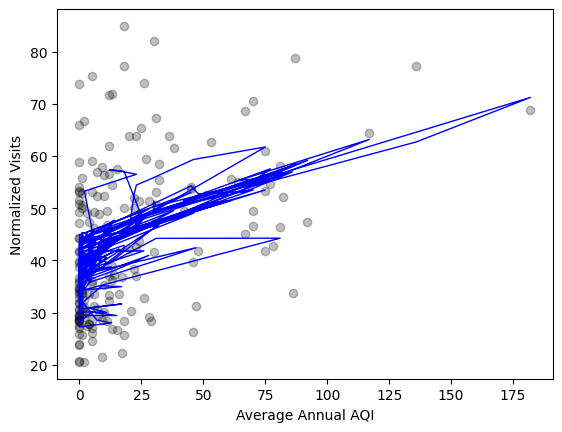

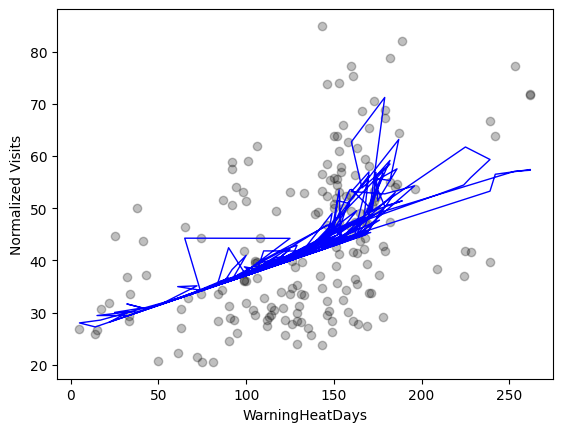

In [279]:
df_hospital_aqi_heat = pd.merge(df_hospital_aqi[["CountyName", "Year", "NormalizedVisits", "days over 100"]], heat_index_counts, on=["Year", "CountyName"], how='inner')
print(len(df_hospital_aqi_heat))
df_hospital_aqi_heat.head(n=50)

x = df_hospital_aqi_heat[["WarningHeatDays", "days over 100"]]
# x = df_hospital_aqi_heat["WarningHeatDays"]
y = df_hospital_aqi_heat["NormalizedVisits"]

# In order to have an intercept, we need to add a column of 1's to X
x2 = sm.add_constant(x)

# Fit the simple linear regression
sm_model = sm.OLS(y, x2)
results = sm_model.fit()
print(results.summary())

# Make predictions using the linear regression
y_pred = results.predict(x2)

# Plot 
plt.scatter(df_hospital_aqi_heat["days over 100"], y, color='black', alpha=0.25)
plt.plot(df_hospital_aqi_heat["days over 100"], y_pred, color='blue', linewidth=1)
plt.xlabel('Average Annual AQI')
plt.ylabel('Normalized Visits')
plt.show()

# Repeat for Heat Index
plt.scatter(df_hospital_aqi_heat["WarningHeatDays"], y, color='black', alpha=0.25)
plt.plot(df_hospital_aqi_heat["WarningHeatDays"], y_pred, color='blue', linewidth=1)
plt.xlabel('WarningHeatDays')
plt.ylabel('Normalized Visits')
plt.show()

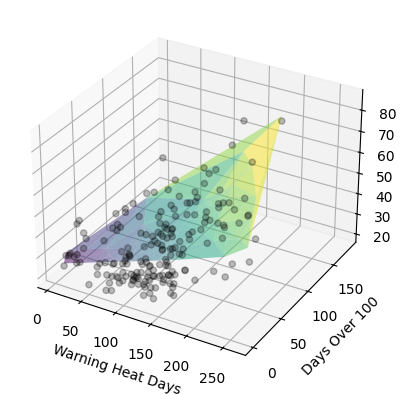

In [280]:
from mpl_toolkits.mplot3d import Axes3D

# Prepare the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of actual data points
ax.scatter(df_hospital_aqi_heat["WarningHeatDays"], df_hospital_aqi_heat["days over 100"], y, color='black', alpha=0.25)

# Plot the prediction surface
ax.plot_trisurf(df_hospital_aqi_heat["WarningHeatDays"], df_hospital_aqi_heat["days over 100"], y_pred, cmap='viridis', linewidth=0, alpha=0.5)

# Set labels
ax.set_xlabel('Warning Heat Days')
ax.set_ylabel('Days Over 100')
ax.set_zlabel('Normalized Visits')

plt.show()


205
      CountyName  Year  NormalizedVisits  Avg Max Air Temp (F)  \
0        Alameda  2015         59.077970             72.678767   
1        Alameda  2016         54.007690             71.680301   
2        Alameda  2017         53.151746             71.141830   
3        Alameda  2018         46.333914             69.831122   
4        Alameda  2019         44.271327             70.153881   
5         Amador  2015         48.426150             71.498904   
6         Amador  2016         46.202500             69.704645   
7         Amador  2017         43.484706             70.368493   
8         Amador  2018         33.848891             71.027671   
9         Amador  2019         41.755201             69.698904   
10         Butte  2015         49.330914             77.736673   
11         Butte  2016         36.383912             75.762022   
12         Butte  2017         44.227716             77.794345   
13         Butte  2018         42.857413             77.189028   
14    

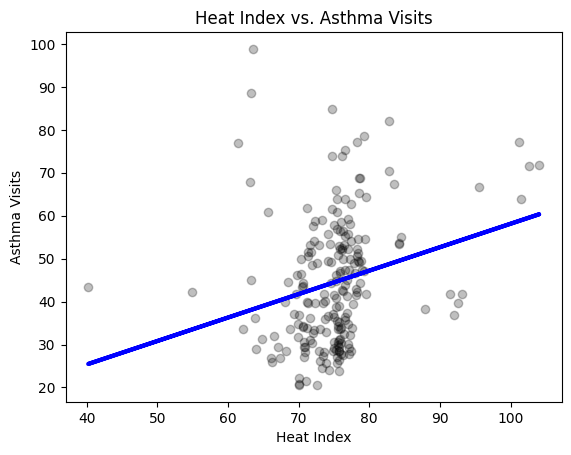